In [10]:
import config
import requests
import json

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

In [11]:
def string_to_tuple(string):
    string = string[1:-1]
    return tuple(map(np.float64, string.split(', ')))

In [12]:
tri_2019 = pd.read_csv("../input/tri_2019_us.csv")
us_boundary = gpd.read_file("../input/s_22mr22.shp")

C:\Users\keyasengupta\AppData\Local\Temp\ipykernel_13724\3353970698.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tri_2019 = pd.read_csv("../input/tri_2019_us.csv")


In [13]:
tri_2019_subset = tri_2019[~tri_2019["8. ST"].isin(["MP", "PR", "GU", "AS", "VI", "AK", "HI"])]
tri_2019_subset = tri_2019_subset[(tri_2019_subset['48. 5.2 - STACK AIR'] > 0) | tri_2019_subset["47. 5.1 - FUGITIVE AIR"] > 0]

In [14]:
tri_2019_subset = tri_2019_subset[(tri_2019_subset['48. 5.2 - STACK AIR'] > tri_2019_subset['48. 5.2 - STACK AIR'].quantile(0.90)) | (tri_2019_subset["47. 5.1 - FUGITIVE AIR"] > tri_2019_subset['47. 5.1 - FUGITIVE AIR'].quantile(0.90))]
tri_2019_subset["geocoded"] = [(tri_2019_subset.iloc[a]['13. LONGITUDE'], tri_2019_subset.iloc[a]['12. LATITUDE']) 
                      for a in range(len(tri_2019_subset))]

In [33]:
#https://soda.demo.socrata.com/resource/earthquakes.json?$limit=5&$offset=0&$order=earthquake_id
places = []
offset = 0
while(1):
    params = {
        "$limit": 1000,
        "$offset": offset
    }
    try:
        #print(requests.get("https://chronicdata.cdc.gov/resource/k86t-wghb.json", params = params).json())
        tmp = requests.get("https://chronicdata.cdc.gov/resource/k86t-wghb.json", params = params).json()
        if(tmp == []):
            break
        places = places + tmp
        offset = offset + 1000
    except:
        break
cdc_places_2019 = pd.concat([pd.DataFrame(places[j], index=[j]) for j in range(len(places))])
cdc_places_2019["geolocation"] = cdc_places_2019["geolocation"].apply(lambda x: (string_to_tuple(x)[1], string_to_tuple(x)[0]))
#cdc_places_2019["geolocation"] = [(round(lon, 5), round(lat, 5)) for lon, lat in cdc_places_2019["geolocation"]]


In [21]:
type(cdc_places_2019["geolocation"].iloc[0][0])

numpy.float64

In [13]:
for c in cdc_places_2019.columns:
    print(c)

stateabbr
placename
placefips
tractfips
place_tractid
population2010
access2_crudeprev
access2_crude95ci
arthritis_crudeprev
arthritis_crude95ci
binge_crudeprev
binge_crude95ci
bphigh_crudeprev
bphigh_crude95ci
bpmed_crudeprev
bpmed_crude95ci
cancer_crudeprev
cancer_crude95ci
casthma_crudeprev
casthma_crude95ci
chd_crudeprev
chd_crude95ci
checkup_crudeprev
checkup_crude95ci
cholscreen_crudeprev
cholscreen_crude95ci
colon_screen_crudeprev
colon_screen_crude95ci
copd_crudeprev
copd_crude95ci
corem_crudeprev
corem_crude95ci
corew_crudeprev
corew_crude95ci
csmoking_crudeprev
csmoking_crude95ci
dental_crudeprev
dental_crude95ci
diabetes_crudeprev
diabetes_crude95ci
highchol_crudeprev
highchol_crude95ci
kidney_crudeprev
kidney_crude95ci
lpa_crudeprev
lpa_crude95ci
mammouse_crudeprev
mammouse_crude95ci
mhlth_crudeprev
mhlth_crude95ci
obesity_crudeprev
obesity_crude95ci
paptest_crudeprev
paptest_crude95ci
phlth_crudeprev
phlth_crude95ci
sleep_crudeprev
sleep_crude95ci
stroke_crudeprev
stroke_c

In [34]:
cdc_places_2019 = cdc_places_2019[~cdc_places_2019.stateabbr.isin(["MP", "PR", "GU", "AS", "VI", "AK", "HI", "FM", "PW", "MH"])]

In [36]:
len(cdc_places_2019)

26921

C:\Users\keyasengupta\anaconda2\envs\py38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\keyasengupta\anaconda2\envs\py38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


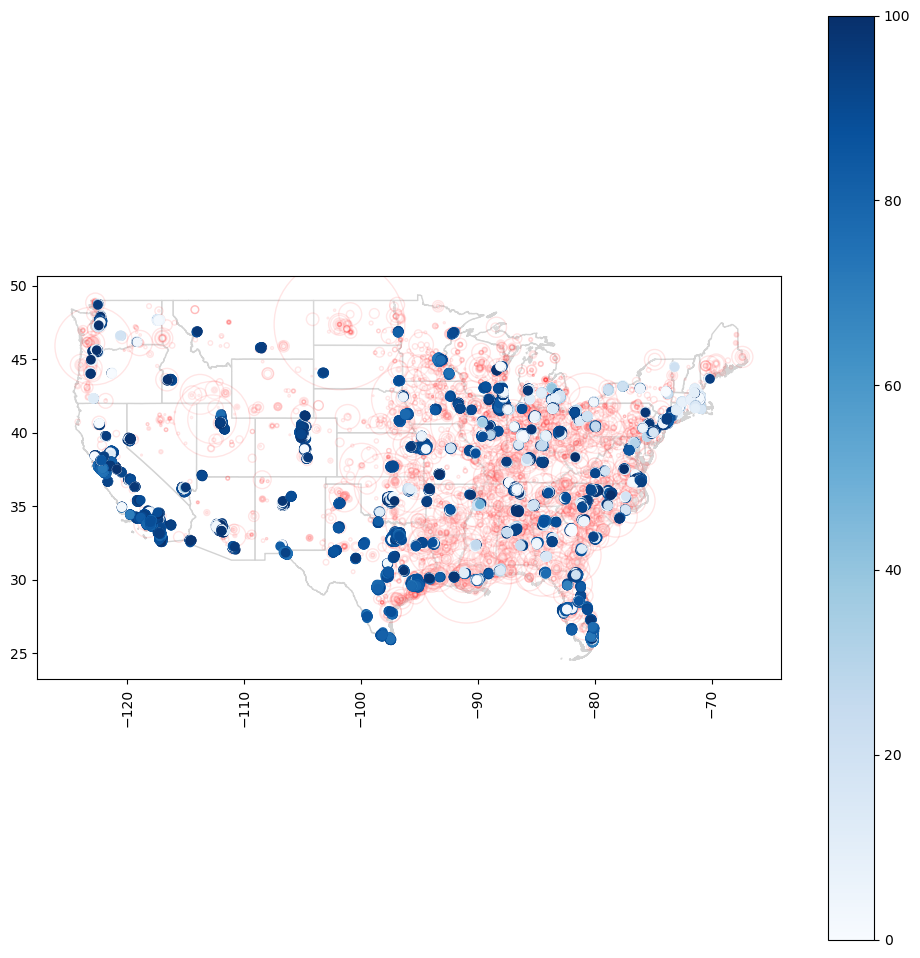

In [32]:
geom = [Point(x) for x in tri_2019_subset.geocoded]
geo_df = gpd.GeoDataFrame(tri_2019_subset, 
                          crs = {'init':'EPSG:4326'}, 
                          geometry = geom)

fig, ax = plt.subplots(1, figsize=(12, 12))
plt.xticks(rotation=90)

contiguous_states = us_boundary[~us_boundary['STATE'].isin(["MP", "PR", "GU", "AS", "VI", "AK", "HI", "FM", "PW", "MH"])]

markersize = (geo_df["48. 5.2 - STACK AIR"] + geo_df["47. 5.1 - FUGITIVE AIR"]) / 2000

contiguous_states.to_crs(epsg=4326).plot(ax=ax, edgecolor='lightgrey', facecolor="white", zorder=1)
geo_df["geometry"].plot(ax=ax, edgecolor="Red", alpha=0.1, markersize=markersize, facecolor="white")

geom = [Point(x) for x in cdc_places_2019.geolocation]
geo_df = gpd.GeoDataFrame(cdc_places_2019, 
                          crs = {'init':'EPSG:4326'}, 
                          geometry = geom)

geo_df.plot(column="casthma_crudeprev", cmap="Blues", ax=ax)

bar_info = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=100))
bar_info._A = []
cbar = fig.colorbar(bar_info)
# geo_df.plot(column="48. 5.2 - STACK AIR", alpha = 0.2, cmap="Purples", ax=ax)

# bar_info = plt.cm.ScalarMappable(cmap="Purples")
# bar_info._A = []
# cbar = fig.colorbar(bar_info)